<a href="https://colab.research.google.com/github/kinaya18/Deep-Learning/blob/main/Week-7/Seq2Seq_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Muhammad Aizar Yazid / 1103223097

## Import

In [5]:
!pip install --upgrade datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from transformers import T5Tokenizer
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from nltk.translate.bleu_score import sentence_bleu


## Set Hyperparameters And Data Preprocessing

In [2]:
MODEL_NAME = "t5-base"
BATCH_SIZE = 64
MAX_LEN = 128
EMBED_SIZE = 256
HIDDEN_SIZE = 512
NUM_EPOCHS = 15
LEARNING_RATE = 0.001
EARLY_STOPPING_PATIENCE = 3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Load tokenizer dan subset dataset
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
dataset = load_dataset("wmt14", "de-en")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/280M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/265M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/273M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/474k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/509k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4508785 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3003 [00:00<?, ? examples/s]

In [6]:
# Ambil subset kecil dari dataset untuk keperluan testing atau pengembangan
small_train = dataset['train'].select(range(1000)) # Ganti 1000 dengan jumlah data yang diinginkan
small_test = dataset['test'].select(range(100))   # Ganti 100 dengan jumlah data yang diinginkan

def tokenize_batch(batch):
    src_texts = [example['de'] for example in batch['translation']]
    tgt_texts = [example['en'] for example in batch['translation']]

    src = tokenizer(src_texts, padding='max_length', truncation=True, max_length=MAX_LEN)
    tgt = tokenizer(tgt_texts, padding='max_length', truncation=True, max_length=MAX_LEN)

    return {
        'src_input_ids': src['input_ids'],
        'src_attention_mask': src['attention_mask'],
        'tgt_input_ids': tgt['input_ids'],
        'tgt_attention_mask': tgt['attention_mask']
    }

tokenized_train = small_train.map(tokenize_batch, batched=True, remove_columns=["translation"])
tokenized_test = small_test.map(tokenize_batch, batched=True, remove_columns=["translation"])

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

## Dataset Torch

In [7]:
class TranslationDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        src = torch.tensor(self.data[idx]['src_input_ids'])
        tgt = torch.tensor(self.data[idx]['tgt_input_ids'])
        return src, tgt

In [8]:
train_data = TranslationDataset(tokenized_train)
test_data = TranslationDataset(tokenized_test)

In [9]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

## Sequence To Sequence Model

In [10]:
class Seq2Seq(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(Seq2Seq, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.encoder_lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.decoder_lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, src, tgt):
        embedded_src = self.embedding(src)
        _, (hidden, cell) = self.encoder_lstm(embedded_src)

        embedded_tgt = self.embedding(tgt)
        output, _ = self.decoder_lstm(embedded_tgt, (hidden, cell))
        output = self.fc(output)
        return output

In [11]:
VOCAB_SIZE = tokenizer.vocab_size
model = Seq2Seq(VOCAB_SIZE, EMBED_SIZE, HIDDEN_SIZE).to(DEVICE)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Model Training

In [12]:
best_val_loss = float('inf')
patience = 0
train_losses, val_losses = [], []
accuracies, precisions, recalls, f1s, bleus = [], [], [], [], []

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    for src, tgt in train_loader:
        src, tgt = src.to(DEVICE), tgt.to(DEVICE)
        output = model(src, tgt)
        output = output[:, 1:].reshape(-1, VOCAB_SIZE)
        tgt = tgt[:, 1:].reshape(-1)
        loss = criterion(output, tgt)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for src, tgt in test_loader:
            src, tgt = src.to(DEVICE), tgt.to(DEVICE)
            output = model(src, tgt)
            output = output[:, 1:].reshape(-1, VOCAB_SIZE)
            tgt = tgt[:, 1:].reshape(-1)
            loss = criterion(output, tgt)
            total_val_loss += loss.item()

            preds = output.argmax(dim=1).detach().cpu().numpy()
            labels = tgt.detach().cpu().numpy()

            # Filter padding tokens
            pad_id = tokenizer.pad_token_id
            valid_indices = [i for i in range(len(labels)) if labels[i] != pad_id]
            filtered_preds = [preds[i] for i in valid_indices]
            filtered_labels = [labels[i] for i in valid_indices]

            all_preds.extend(filtered_preds)
            all_labels.extend(filtered_labels)

    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    # Calculate BLEU score
    bleu_score = sentence_bleu([filtered_labels], filtered_preds)

    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1s.append(f1)
    bleus.append(bleu_score)

    # Print metrics
    print(f"Epoch {epoch+1}")
    print(f"Train Loss : {avg_train_loss:.4f}")
    print(f"Val Loss   : {avg_val_loss:.4f}")
    print(f"Accuracy   : {acc:.4f}")
    print(f"Precision  : {prec:.4f}")
    print(f"Recall     : {rec:.4f}")
    print(f"F1 Score   : {f1:.4f}")
    print(f"BLEU Score : {bleu_score:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience = 0
    else:
        patience += 1
        if patience >= EARLY_STOPPING_PATIENCE:
            print("Early stopping triggered")
            break

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Epoch 1
Train Loss : 7.8643
Val Loss   : 7.2075
Accuracy   : 0.2593
Precision  : 0.0068
Recall     : 0.0094
F1 Score   : 0.0068
BLEU Score : 0.0000
Epoch 2
Train Loss : 4.9159
Val Loss   : 6.1372
Accuracy   : 0.3875
Precision  : 0.0207
Recall     : 0.0278
F1 Score   : 0.0221
BLEU Score : 0.0663
Epoch 3
Train Loss : 3.8453
Val Loss   : 5.5017
Accuracy   : 0.4748
Precision  : 0.0556
Recall     : 0.0702
F1 Score   : 0.0587
BLEU Score : 0.1501
Epoch 4
Train Loss : 3.0429
Val Loss   : 5.0690
Accuracy   : 0.5378
Precision  : 0.1224
Recall     : 0.1424
F1 Score   : 0.1277
BLEU Score : 0.2038
Epoch 5
Train Loss : 2.3991
Val Loss   : 4.7357
Accuracy   : 0.5797
Precision  : 0.1739
Recall     : 0.1974
F1 Score   : 0.1798
BLEU Score : 0.2359
Epoch 6
Train Loss : 1.8849
Val Loss   : 4.4749
Accuracy   : 0.6177
Precision  : 0.2190
Recall     : 0.2477
F1 Score   : 0.2269
BLEU Score : 0.2836
Epoch 7
Train Loss : 1.4810
Val Loss   : 4.2636
Accuracy   : 0.6497
Precision  : 0.2787
Recall     : 0.3058
F1 S

## Data Visualisasi

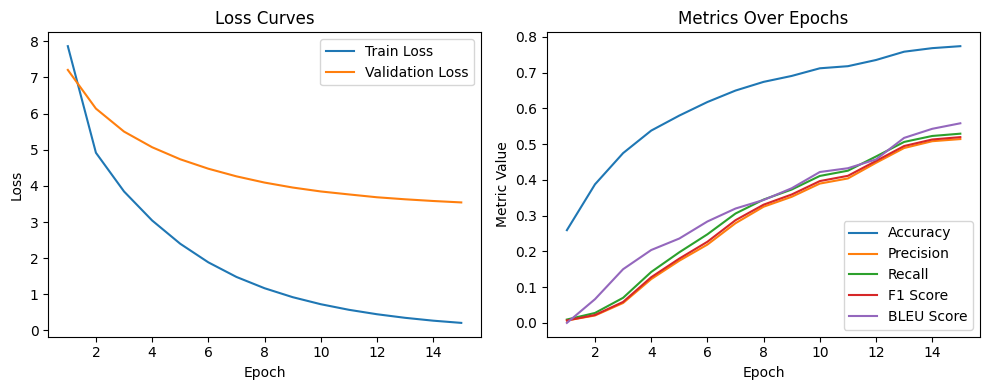

In [13]:
epochs = list(range(1, len(train_losses) + 1))
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, label='Accuracy')
plt.plot(epochs, precisions, label='Precision')
plt.plot(epochs, recalls, label='Recall')
plt.plot(epochs, f1s, label='F1 Score')
plt.plot(epochs, bleus, label='BLEU Score')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Metrics Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()